## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [ ]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [119]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [120]:
len(fmnist_dataset_test)

10000

In [121]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [173]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):    
        out = self.model(inp)
        return out

In [174]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
       BatchNorm1d-3                  [-1, 100]             200
              ReLU-4                  [-1, 100]               0
            Linear-5                   [-1, 10]           1,010
        LogSoftmax-6                   [-1, 10]               0
Total params: 79,710
Trainable params: 79,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


Your experiments come here:

In [175]:
from tqdm.autonotebook import tqdm

model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()
epochs = 20

def train(model, train_loader, test_loader, opt, loss_func, plot = True):
    train_loss = []
    test_loss = []
    history_score = []

    for epoch in tqdm(range(epochs)):
        model.train()
        loss_sum = 0
        for input, target in tqdm(train_loader, desc='Train', leave=(epoch == epochs-1)):
            input, target = input.to(device), target.to(device)
            output = model.forward(input)
            loss = loss_func(output, target)
            loss_sum += loss.item()
            opt.zero_grad()
            loss.backward()
            opt.step()
        train_loss.append(loss_sum / len(train_loader))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for input, target in tqdm(test_loader, desc='Test', leave=(epoch == epochs-1)):
                input, target = input.to(device), target.to(device)

                probs = model.forward(input)
                loss_sum += loss_func(probs, target).item()

                _, preds = torch.max(probs, axis=-1)
                correct += (preds == target).sum().item()
                num += len(input)
                    
        test_loss.append(loss_sum / len(test_loader))
        history_score.append(correct / num) 

    return train_loss, test_loss, history_score

data = train(model, train_loader, test_loader, opt, loss_func)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/469 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

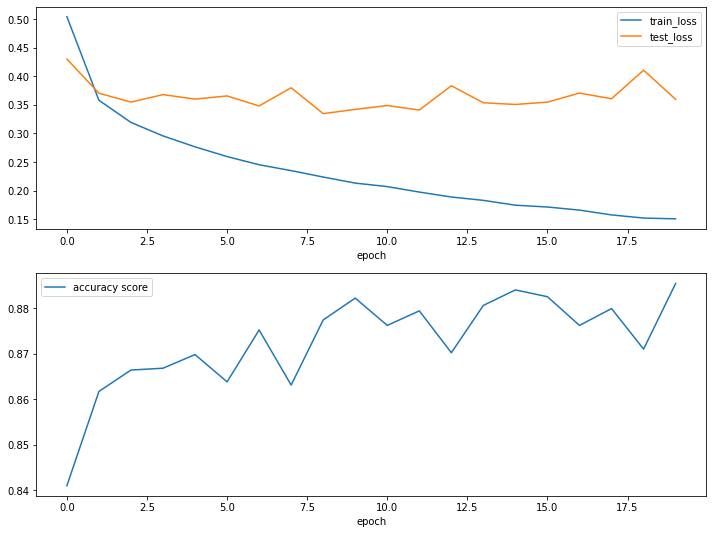

In [176]:
def plot(train_loss, test_loss, history_score):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)      
    plt.xlabel("epoch")
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(history_score, label="accuracy score")
    plt.legend()

plot(*data)

In [177]:
def score(model, test_loader):
    acc = 0
    batches = 0

    for x_batch, y_batch in test_loader:
        batches += 1
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        model.eval()
        preds = torch.argmax(model.forward(x_batch), dim=1)
        acc += (preds==y_batch).cpu().numpy().mean()

    print(f'Test accuracy {acc / batches:.3}')

score(model, test_loader)

Test accuracy 0.885


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [178]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [179]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (1, 28, 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
            Conv2d-3           [-1, 16, 20, 20]           2,416
              ReLU-4           [-1, 16, 20, 20]               0
           Flatten-5                 [-1, 6400]               0
            Linear-6                  [-1, 120]         768,120
              ReLU-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              ReLU-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
Total params: 781,706
Trainable params: 781,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 2.98
Estimated T

In [180]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()

smaller_train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(fmnist_dataset_train, indices=range(len(fmnist_dataset_train) // 3)), 
                                                   batch_size=128,
                                                   shuffle=True,
                                                   num_workers=2)

data = train(model, smaller_train_loader, test_loader, opt, loss_func)

  0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

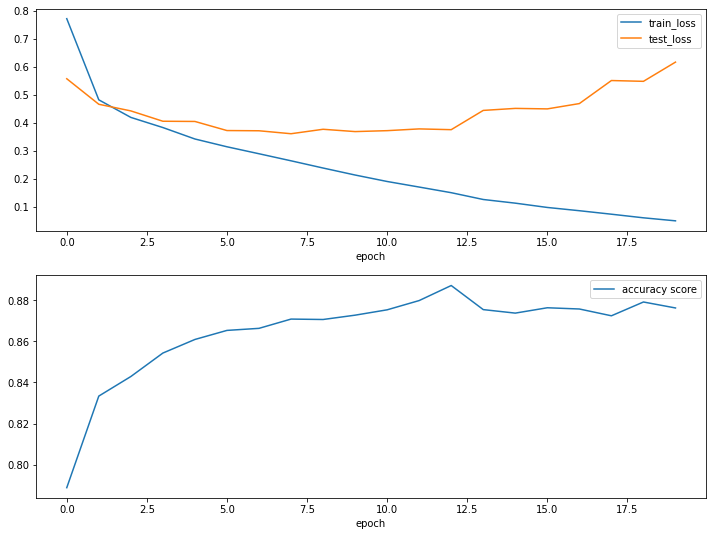

In [181]:
plot(*data)

As we can see, the test loss starts to increase at some point, which is a clear sign of overfitting. There is no point in increasing the number of epochs because the model would only overfit more.

In [182]:
score(model, test_loader)

Test accuracy 0.875


The test accuracy score is expectedly lower than that of the non-overfitting network.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [198]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.5),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(84, num_classes)
        )

    def forward(self, inp):       
        out = self.model(inp)
        return out

In [199]:
torchsummary.summary(FixedNeuralNetwork().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
         Dropout2d-4            [-1, 6, 12, 12]               0
            Conv2d-5             [-1, 16, 8, 8]           2,416
              ReLU-6             [-1, 16, 8, 8]               0
         MaxPool2d-7             [-1, 16, 4, 4]               0
           Flatten-8                  [-1, 256]               0
            Linear-9                  [-1, 120]          30,840
      BatchNorm1d-10                  [-1, 120]             240
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
      BatchNorm1d-13                   [-1, 84]             168
             ReLU-14                   

In [200]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()
epochs = 30

# use the same train data (smaller) as in the overfitting network to see that we have indeed fixed it
data = train(model, smaller_train_loader, test_loader, opt, loss_func)

  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/40 [00:00<?, ?it/s]

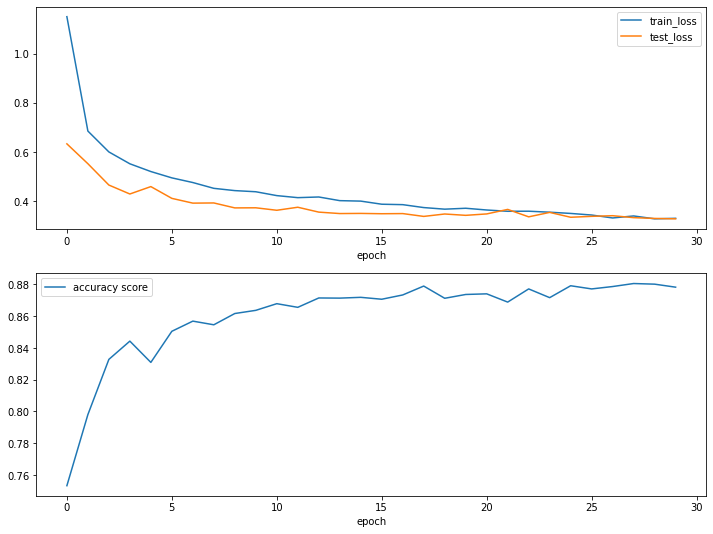

In [201]:
plot(*data)

In [202]:
score(model, test_loader)

Test accuracy 0.881


We have fixed the overfitting problem. That allowed us to increase the number of epochs and produce a better test accuracy score. However, that score is still lower that that of the very dirst model, but that is most probably due to the fact that we use only 30% of the dataset here (see comment in the cell where we train the current model).

### Conclusions:

We can see that even a more complicated model can produce a worse result than a more simple one due to overfitting, so one must be cautious and monitor the loss graphs so as not to allow the model to overfit.

One additional conclusion I have come to during trying out different models is that adding Dropout layers lowers the value of the best possible score the model can produce without overfitting.